#**Importing required libraries and packages**

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from scipy.interpolate import interp1d
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import statsmodels.api as sm
import statsmodels.formula.api as smf

# **Exploratory Data Analysis**

In [ ]:
dataset = pd.read_excel('data.xlsx')
#dtale.show(dataset,open_browser=True)

#**Data preprocessing & Feature Engineering**


In [39]:
df = pd.read_excel('data.xlsx')
df['CSS']= df['CSS-DT'] + df['CSS-EXC'] + df['CSS-RSN'] + df['CSS-CMP']
shai_columns = ['SHAI-HA-1', 'SHAI-HA-2','SHAI-HA-3', 'SHAI-HA-4','SHAI-HA-5', 'SHAI-HA-6','SHAI-HA-7',
                'SHAI-HA-8','SHAI-HA-9', 'SHAI-HA-10','SHAI-HA-11', 'SHAI-HA-12',
                'SHAI-HA-13', 'SHAI-HA-14','SHAI-NC-15', 'SHAI-NC-16','SHAI-NC-17','SHAI-NC-18']
df['CSS_Category'] = df['CSS'].apply(lambda x: 'Non CYB' if x < 32 else 'CYB')
df['CSS_Category'].value_counts()

,count
CSS_Category,
Non CYB,258
CYB,146


In [40]:

ders_columns = [col for col in df.columns if col.startswith('DERS-')]

# Maximum and minimum values of the scale
max_scale = 5
min_scale = 1

# Reverse scoring for selected columns
df[ders_columns] = df[ders_columns].apply(lambda x: max_scale + min_scale - x)

# Create a new column 'DERS' which is the total of all reversed scores
df['DERS'] = df[ders_columns].sum(axis=1)


# **Statistical analysis & corelation**

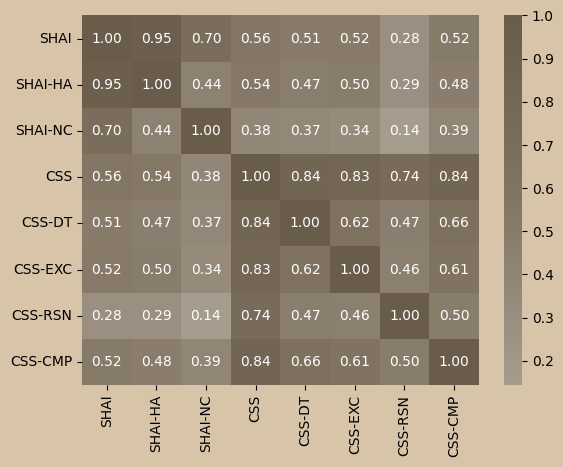

In [41]:
columns_to_correlate = ['SHAI', 'SHAI-HA', 'SHAI-NC', 'CSS','CSS-DT','CSS-EXC','CSS-RSN','CSS-CMP']
subset_corr = df[columns_to_correlate].corr()
colors = ['#a69c8e', '#827564', '#695c4a']  # White -> #827564 -> Black
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
plt.gcf().set_facecolor('#d8c4a8')
sns.heatmap(subset_corr, annot=True, cmap=custom_cmap, fmt=".2f")
#plt.title('Pearson Correlation of Health Anxiety (SHAI) with Cyberchondria (CSS-12)')
plt.show()

***The moderating role of difficulty in emotional regulation (ders) between the realtionship of Health Anxiety (SHAI-18) with Cyberchondria (CSS-12)***

In [42]:
# Define the formula for multiple regression with interaction
formula = 'CSS ~ SHAI + DERS + SHAI_DERS'
# Create interaction term SHAI*DERS
df['SHAI_DERS'] = df['SHAI'] * df['DERS']

# Fit the model using OLS (Ordinary Least Squares)
model = smf.ols(formula=formula, data=df).fit()

# Print the summary of results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CSS   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     79.03
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           3.65e-40
Time:                        19:33:11   Log-Likelihood:                -1387.8
No. Observations:                 404   AIC:                             2784.
Df Residuals:                     400   BIC:                             2800.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.7481      5.300      6.556      0.0

***difference in health anxiety (shai) on basis of gender***

In [43]:
gender_means_SHAI = df.groupby('GENDER')['SHAI'].mean()
gender_means_SHAI

,SHAI
GENDER,
1,12.592308
2,15.743396
3,17.111111


# **Regression Model**

In [44]:
reg_data = df[shai_columns + [ 'CSS']]
reg_data.isnull().sum()
reg_data.dropna(inplace=True)
print(reg_data.shape)
X = reg_data[shai_columns]
Y = reg_data['CSS']

(403, 19)


<ipython-input-44-70ccb0dc6826>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data.dropna(inplace=True)


In [45]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

### Model 1: K-Nearest Neighbors
params = {'n_neighbors': [2, 3, 7, 8, 9]}
knn = KNeighborsRegressor()
grid_knn = GridSearchCV(knn, params, cv=5)
grid_knn.fit(x_train, y_train)
knn_pred = grid_knn.predict(x_test)

knn_train_score = grid_knn.score(x_train, y_train)
knn_test_score = grid_knn.score(x_test, y_test)
knn_rmse = np.sqrt(mean_squared_error(y_test, knn_pred))

### Model 2: Bayesian Ridge Regression
BayReg = BayesianRidge(fit_intercept=True)
BayReg.fit(x_train, y_train)
bay_pred = BayReg.predict(x_test)

bay_train_score = BayReg.score(x_train, y_train)
bay_test_score = BayReg.score(x_test, y_test)
bay_rmse = np.sqrt(mean_squared_error(y_test, bay_pred))

### Model 3: Linear Regression
LR = LinearRegression()
LR.fit(x_train, y_train)
lr_pred = LR.predict(x_test)

lr_train_score = LR.score(x_train, y_train)
lr_test_score = LR.score(x_test, y_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

### Display Results
print("K-Nearest Neighbors Regression:")
print(f"  Best Parameters: {grid_knn.best_params_}")
print(f"  Training R-squared: {knn_train_score:.3f}")
print(f"  Testing R-squared: {knn_test_score:.3f}")
print(f"  RMSE: {knn_rmse:.3f}\n")

print("Bayesian Ridge Regression:")
print(f"  Training R-squared: {bay_train_score:.3f}")
print(f"  Testing R-squared: {bay_test_score:.3f}")
print(f"  RMSE: {bay_rmse:.3f}\n")

print("Linear Regression:")
print(f"  Training R-squared: {lr_train_score:.3f}")
print(f"  Testing R-squared: {lr_test_score:.3f}")
print(f"  RMSE: {lr_rmse:.3f}\n")


K-Nearest Neighbors Regression:
  Best Parameters: {'n_neighbors': 2}
  Training R-squared: 0.875
  Testing R-squared: 0.097
  RMSE: 9.527

Bayesian Ridge Regression:
  Training R-squared: 0.354
  Testing R-squared: 0.411
  RMSE: 7.690

Linear Regression:
  Training R-squared: 0.360
  Testing R-squared: 0.443
  RMSE: 7.478



In [27]:
### Input SHAI-18 Scores for Prediction
print("\n--- Predict CSS Score ---")
SHAI_input = np.array([list(map(float, input("Enter SHAI-18 scores as space-separated values: ").split()))]).reshape(1, -1)

print(f"KNN Prediction: {grid_knn.predict(SHAI_input)[0]:.2f}")
print(f"Bayesian Ridge Prediction: {BayReg.predict(SHAI_input)[0]:.2f}")
print(f"Linear Regression Prediction: {LR.predict(SHAI_input)[0]:.2f}")



--- Predict CSS Score ---
Enter SHAI-18 scores as space-separated values: 2 3 4 1 1 2 1 2 1 5 1 2 1 2 1 1 2 1
KNN Prediction: 36.50
Bayesian Ridge Prediction: 38.21
Linear Regression Prediction: 38.75


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but BayesianRidge was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


#**Classification Model**

In [46]:
clsf_data = df[shai_columns + [ 'CSS_Category']]
clsf_data.shape
clsf_data.isnull().sum()
clsf_data.dropna(inplace=True)
clsf_data.shape
X = clsf_data[shai_columns]


y = clsf_data['CSS_Category']

print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

Shape of X (features): (403, 18)
Shape of y (target): (403,)


<ipython-input-46-0dd0423dad25>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clsf_data.dropna(inplace=True)


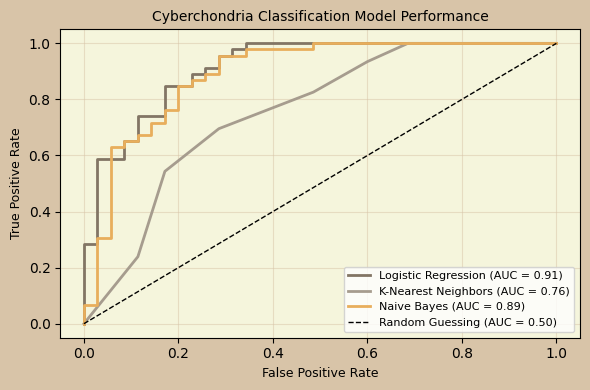

In [47]:
le = LabelEncoder()
y = le.fit_transform(clsf_data['CSS_Category'])

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Model 1: Logistic Regression
model1 = LogisticRegression()
model1.fit(X_train, y_train)
y_prob_lr = model1.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Model 2: K-Nearest Neighbors
model2 = KNeighborsClassifier(n_neighbors=9)
model2.fit(X_train, y_train)
y_prob_knn = model2.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Model 3: Gaussian Naive Bayes
model3 = GaussianNB()
model3.fit(X_train, y_train)
y_prob_gn = model3.predict_proba(X_test)[:, 1]
fpr_gn, tpr_gn, _ = roc_curve(y_test, y_prob_gn)
roc_auc_gn = auc(fpr_gn, tpr_gn)

# Plotting the ROC curves
plt.figure(figsize=(6,4))

plt.gca().set_facecolor("#F5F5DC")

# Plotting ROC curves
plt.plot(fpr_lr, tpr_lr, color="#827564", label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})", linewidth=2)
plt.plot(fpr_knn, tpr_knn, color="#a69c8e", label=f"K-Nearest Neighbors (AUC = {roc_auc_knn:.2f})", linewidth=2)
plt.plot(fpr_gn, tpr_gn, color="#e8ae5c", label=f"Naive Bayes (AUC = {roc_auc_gn:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)', linewidth=1)

# Adding labels, legend, and grid
plt.xlabel('False Positive Rate', fontsize=9)
plt.ylabel('True Positive Rate', fontsize=9)
plt.title('Cyberchondria Classification Model Performance', fontsize=10)
plt.legend(loc='lower right', fontsize=8)
plt.grid(alpha=0.5, color="#d8c4a8")
plt.tight_layout()
plt.gcf().set_facecolor('#d8c4a8')
plt.show()

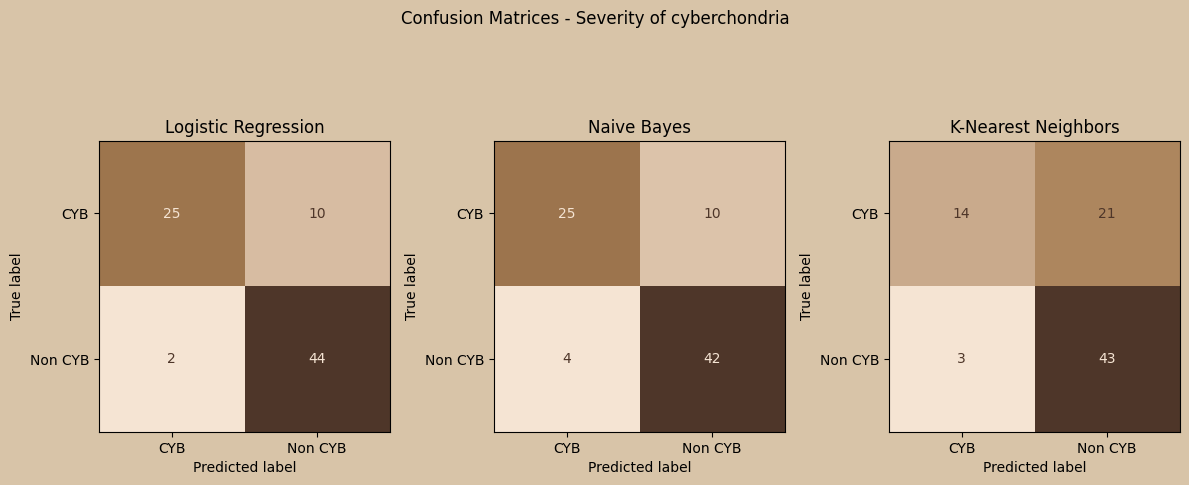

In [48]:
# Create a custom colormap with brown shades
brown_cmap = LinearSegmentedColormap.from_list("brown_shades", ["#f5e4d3", "#a67c52", "#4e3629"])

# Predictions for each model
y_pred_lr = model1.predict(X_test)  # Logistic Regression
y_pred_knn = model2.predict(X_test)  # K-Nearest Neighbors
y_pred_nb = model3.predict(X_test)  # Naive Bayes

# Confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Create subplots for confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Confusion Matrices - Severity of cyberchondria", fontsize=12, y=1.02)
fig.patch.set_facecolor('#d8c4a8')

# Logistic Regression
ConfusionMatrixDisplay(cm_lr, display_labels=le.classes_).plot(ax=axes[0], cmap=brown_cmap, colorbar=False)
axes[0].set_title("Logistic Regression")

# K-Nearest Neighbors
ConfusionMatrixDisplay(cm_knn, display_labels=le.classes_).plot(ax=axes[2], cmap=brown_cmap, colorbar=False)
axes[2].set_title("K-Nearest Neighbors")

# Naive Bayes
ConfusionMatrixDisplay(cm_nb, display_labels=le.classes_).plot(ax=axes[1], cmap=brown_cmap, colorbar=False)
axes[1].set_title("Naive Bayes")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [49]:
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

              precision    recall  f1-score   support

         CYB       0.93      0.71      0.81        35
     Non CYB       0.81      0.96      0.88        46

    accuracy                           0.85        81
   macro avg       0.87      0.84      0.84        81
weighted avg       0.86      0.85      0.85        81

              precision    recall  f1-score   support

         CYB       0.86      0.71      0.78        35
     Non CYB       0.81      0.91      0.86        46

    accuracy                           0.83        81
   macro avg       0.83      0.81      0.82        81
weighted avg       0.83      0.83      0.82        81

              precision    recall  f1-score   support

         CYB       0.82      0.40      0.54        35
     Non CYB       0.67      0.93      0.78        46

    accuracy                           0.70        81
   macro avg       0.75      0.67      0.66        81
weighted avg       0.74      0.70      0.68        81

